<a href="https://colab.research.google.com/github/Volks44/ML_Lab_Comp/blob/main/Competition_ARIMA_RandForClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
!pip install pmdarima --q
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.7 MB/s eta 0:00:00




---



# Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML Laboratory/Competition/public_data.csv')
print(df.head())

   rowID  season  periodID  day_in_period  hour  minute  holyday  weekday  \
0      0       1        18              0     0       0    False        2   
1      1       1        18              0     0      15    False        2   
2      2       1        18              0     0      30    False        2   
3      3       1        18              0     0      45    False        2   
4      4       1        18              0     1       0    False        2   

           ke      hupx  afrr_fel     afrr_le  mfrr_fel  mfrr_le        afrr  \
0  899.343121  287.7194    0.0000 -103.196933       0.0      0.0 -212.845947   
1  899.374587  287.7194   55.9286   -5.617200       0.0      0.0  263.427160   
2  899.303875  287.7194   69.6826   -9.355800       0.0      0.0  273.927320   
3  899.299787  287.7194   30.2718  -16.943567       0.0      0.0  132.621040   
4  897.436947  283.6309   25.9714  -12.064167       0.0      0.0  151.888080   

   solar_becsult_dayahead  rendszerterheles_terv  target

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89760 entries, 0 to 89759
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   rowID                   89760 non-null  int64  
 1   season                  89760 non-null  int64  
 2   periodID                89760 non-null  int64  
 3   day_in_period           89760 non-null  int64  
 4   hour                    89760 non-null  int64  
 5   minute                  89760 non-null  int64  
 6   holyday                 89760 non-null  bool   
 7   weekday                 89760 non-null  int64  
 8   ke                      71808 non-null  float64
 9   hupx                    71808 non-null  float64
 10  afrr_fel                71808 non-null  float64
 11  afrr_le                 71808 non-null  float64
 12  mfrr_fel                71808 non-null  float64
 13  mfrr_le                 71808 non-null  float64
 14  afrr                    71808 non-null

In [ ]:
np.unique(df['day_in_period'])

array([0, 1, 2, 3, 4])

In [ ]:
np.unique(df['target_flag'])

array([ 0.,  1., nan])

## Datasplit

In [ ]:
df1 = df[df['day_in_period'].isin([0, 1, 2, 3])]
df2 = df[df['day_in_period'] == 4]



---



## Feature Selection

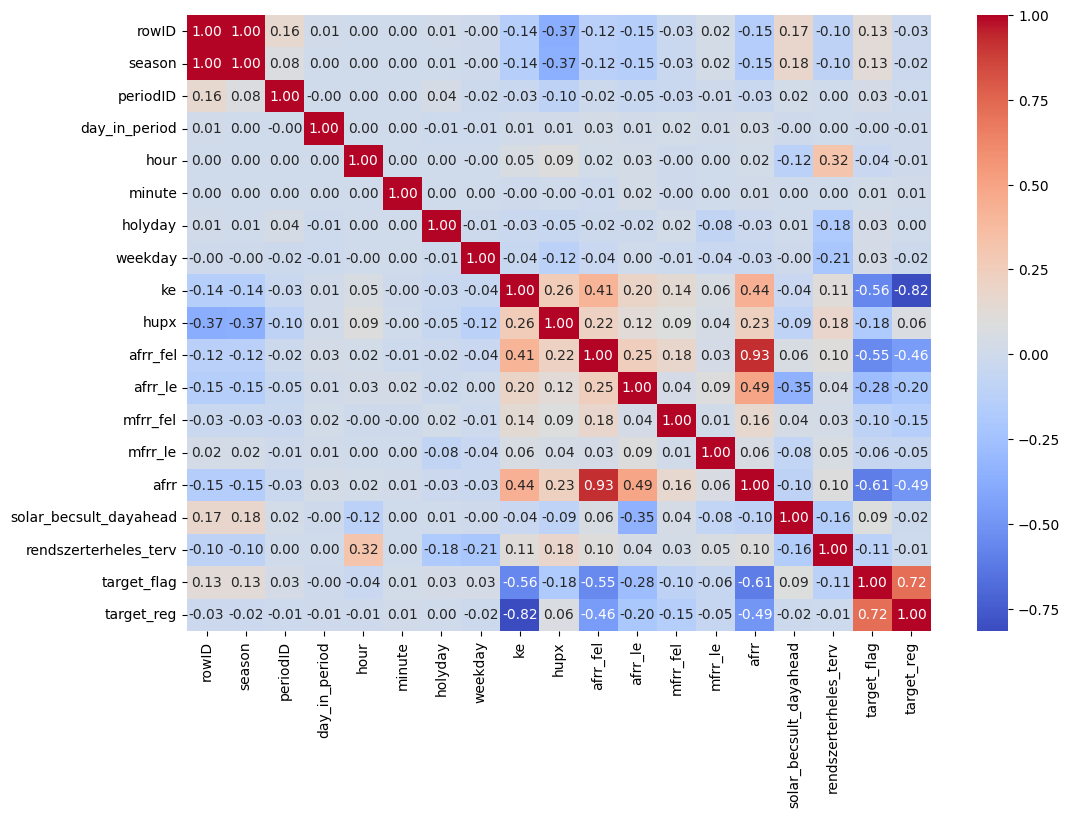

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

In [ ]:
X = df1.drop(columns=['rowID','target_flag','target_reg'])
y = df1['target_flag']

model = RandomForestClassifier()
model.fit(X, y)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

                   Feature  Importance
7                       ke    0.593980
13                    afrr    0.127062
10                 afrr_le    0.095742
9                 afrr_fel    0.086945
8                     hupx    0.034130
0                   season    0.017947
15   rendszerterheles_terv    0.010971
1                 periodID    0.008967
3                     hour    0.006367
14  solar_becsult_dayahead    0.004917
6                  weekday    0.004332
4                   minute    0.003871
2            day_in_period    0.002926
11                mfrr_fel    0.000958
12                 mfrr_le    0.000556
5                  holyday    0.000329


In [ ]:
model = RandomForestClassifier()
rfe = RFE(model, n_features_to_select=10)  # Select top 10 features
rfe = rfe.fit(X, y)

print("Selected Features:", X.columns[rfe.support_])

Selected Features: Index(['season', 'periodID', 'hour', 'ke', 'hupx', 'afrr_fel', 'afrr_le',
       'afrr', 'solar_becsult_dayahead', 'rendszerterheles_terv'],
      dtype='object')


In [ ]:
selected_features = X.columns[rfe.support_]

In [ ]:
# Assume selected features are stored in 'selected_features'
X = df1[selected_features]
y_flag = df1['target_flag']
y_reg = df1['target_reg']

# Split data for classification (target_flag)
X_train_flag, X_test_flag, y_train_flag, y_test_flag = train_test_split(X, y_flag, test_size=0.2, random_state=42)

# Split data for regression (target_reg)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

In [ ]:
# Initialize and train the model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_flag, y_train_flag)

# Predict on test set
y_pred_flag = clf.predict(X_test_flag)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test_flag, y_pred_flag))
print("Classification Report:\n", classification_report(y_test_flag, y_pred_flag))
print("Confusion Matrix:\n", confusion_matrix(y_test_flag, y_pred_flag))

Accuracy: 0.990112797660493
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      4838
         1.0       0.99      0.99      0.99      9524

    accuracy                           0.99     14362
   macro avg       0.99      0.99      0.99     14362
weighted avg       0.99      0.99      0.99     14362

Confusion Matrix:
 [[4765   73]
 [  69 9455]]


In [ ]:
# Initialize and train the model
reg = RandomForestRegressor(random_state=42)
reg.fit(X_train_reg, y_train_reg)

# Predict on test set
y_pred_reg = reg.predict(X_test_reg)

# Evaluate the model
print("Mean Absolute Error:", mean_absolute_error(y_test_reg, y_pred_reg))
print("Mean Squared Error:", mean_squared_error(y_test_reg, y_pred_reg))
print("R^2 Score:", r2_score(y_test_reg, y_pred_reg))

Mean Absolute Error: 1.220106413184216
Mean Squared Error: 132.43793102895458
R^2 Score: 0.9979206027512351




---
# Time Series Prediction


In [ ]:
#split = int(len(df1) * 0.8)

# train = df1.iloc[:split]
# test = df1.iloc[split:]

train = df1
test = df2

train.shape, test.shape

((71808, 19), (17952, 19))

## 'ke'



```
model = auto_arima(train['ke'], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=651285.209, Time=121.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=664606.867, Time=1.50 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=659952.664, Time=1.85 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=656452.665, Time=14.55 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=664604.867, Time=0.72 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=61.86 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=651729.058, Time=45.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=651732.591, Time=88.98 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=77.79 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=652209.499, Time=27.72 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=70.49 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=84.56 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=651999.682, Time=149.84 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=47.11 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 793.784 seconds
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                57446
Model:               SARIMAX(2, 1, 2)   Log Likelihood             -325636.605
Date:                Mon, 09 Dec 2024   AIC                         651285.209
Time:                        16:27:57   BIC                         651338.961
Sample:                             0   HQIC                        651301.939
                              - 57446                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.001      0.344      0.731      -0.002       0.003
ar.L1          1.1768      0.007    169.896      0.000       1.163       1.190
ar.L2         -0.2729      0.004    -67.000      0.000      -0.281      -0.265
ma.L1         -1.6411      0.007   -241.828      0.000      -1.654      -1.628
ma.L2          0.6447      0.007     97.528      0.000       0.632       0.658
sigma2      4804.0455      2.934   1637.626      0.000    4798.296    4809.795
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):         106056219.60
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               2.01   Skew:                             4.09
Prob(H) (two-sided):                  0.00   Kurtosis:                       213.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
```



In [ ]:
model = ARIMA(train['ke'], order=(2, 1, 2))
arima_result = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [ ]:
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                     ke   No. Observations:                71808
Model:                 ARIMA(2, 1, 2)   Log Likelihood             -425985.624
Date:                Wed, 11 Dec 2024   AIC                         851981.249
Time:                        19:01:58   BIC                         852027.158
Sample:                             0   HQIC                        851995.392
                              - 71808                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1978      0.026      7.654      0.000       0.147       0.248
ar.L2          0.2051      0.015     13.457      0.000       0.175       0.235
ma.L1         -0.6004      0.026    -23.244      0.0

In [ ]:
forecast = arima_result.forecast(steps=len(test['ke']))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
mse = mean_squared_error(test['ke'], forecast)
rmse = np.sqrt(mse)
print(f"MSE: {mse}, Test RMSE: {rmse}")

ValueError: Input contains NaN.

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['ke'], label='Train')
plt.plot(test.index, test['ke'], label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.legend()
plt.show()



---
## 'hupx'


In [ ]:
model2 = ARIMA(train['hupx'], order=(2, 1, 2))
arima_result2 = model2.fit()
forecast2 = arima_result2.forecast(steps=len(test['hupx']))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

---
## 'afrr_fel'

In [ ]:
model3 = ARIMA(train['afrr_fel'], order=(2, 1, 2))
arima_result3 = model3.fit()
forecast3 = arima_result3.forecast(steps=len(test['afrr_fel']))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

---
## 'afrr_le'

In [ ]:
model4 = ARIMA(train['afrr_le'], order=(2, 1, 2))
arima_result4 = model4.fit()
forecast4 = arima_result4.forecast(steps=len(test['afrr_le']))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

---
## 'afrr'

In [ ]:
model5 = ARIMA(train['afrr'], order=(2, 1, 2))
arima_result5 = model5.fit()
forecast5 = arima_result5.forecast(steps=len(test['rowID']))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give



---



In [ ]:
df2['ke'] = np.array(forecast)
df2['hupx'] = np.array(forecast2)
df2['afrr_fel'] = np.array(forecast3)
df2['afrr_le'] = np.array(forecast4)
df2['afrr'] = np.array(forecast5)

<ipython-input-23-9d7d9f3b4890>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ke'] = np.array(forecast)
<ipython-input-23-9d7d9f3b4890>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['hupx'] = np.array(forecast2)
<ipython-input-23-9d7d9f3b4890>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17952 entries, 384 to 89759
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   rowID                   17952 non-null  int64  
 1   season                  17952 non-null  int64  
 2   periodID                17952 non-null  int64  
 3   day_in_period           17952 non-null  int64  
 4   hour                    17952 non-null  int64  
 5   minute                  17952 non-null  int64  
 6   holyday                 17952 non-null  bool   
 7   weekday                 17952 non-null  int64  
 8   ke                      17952 non-null  float64
 9   hupx                    17952 non-null  float64
 10  afrr_fel                17952 non-null  float64
 11  afrr_le                 17952 non-null  float64
 12  mfrr_fel                0 non-null      float64
 13  mfrr_le                 0 non-null      float64
 14  afrr                    17952 non-null  f



---





---



In [ ]:
# Initialize and train the model
reg = RandomForestRegressor(random_state=42)
reg.fit(df1[selected_features], df1['target_reg'])

# Predict on test set
pred_reg = reg.predict(df2[selected_features])

In [ ]:
df2['target_reg'] = np.array(pred_reg)

<ipython-input-26-a664e2198f32>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['target_reg'] = np.array(pred_reg)


In [ ]:
selected_features = np.append(selected_features, 'target_reg')

In [ ]:
selected_features

array(['season', 'periodID', 'hour', 'ke', 'hupx', 'afrr_fel', 'afrr_le',
       'afrr', 'solar_becsult_dayahead', 'rendszerterheles_terv',
       'target_reg'], dtype=object)

In [ ]:
# Initialize and train the model
clf = RandomForestClassifier(random_state=42)
clf.fit(df1[selected_features], df1['target_flag'])

# Predict on test set
pred_flag = clf.predict(df2[selected_features])

In [ ]:
pred_flag

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
np.unique(pred_flag, return_counts=True)

(array([0.]), array([17952]))

In [ ]:
df2['target_flag'] = np.array(pred_flag)

<ipython-input-53-dfc639db5c0b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['target_flag'] = np.array(pred_flag)


In [ ]:
sol = df2[['rowID', 'target_flag']]

In [ ]:
sol.to_csv('result.csv', index=False)